In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

# add project root folder to path to allow import local modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
# import local modules
from helpers import compute_ridge_loss
from helpers import *
from implementations import *
from preprocessing import *

In [22]:
N_Quantiles = 100
Quantile_Transformer = False
Box_Cox= True

## Make custom pipeline to create normal distributions for the features


In [63]:
class Distribution_Transform_Preprocessing(Preprocessing):
    def __init__(self,dataset):
        super().__init__(dataset)
        self.n_quantiles = None
        self.quantile_transformer = None
        self.box_cox= None
    
    def set_dist_quantiles(self,n_quantiles, quantile_transformer, box_cox):
        self.n_quantiles = n_quantiles
        self.quantile_transformer = quantile_transformer
        self.box_cox = box_cox
        
        
    def _feature_engineering(self):
        super()._feature_engineering() 
        
        dataset =self.dataset
        
        if self.quantile_transformer:
            for i in range(self.dataset.shape[1]):
                qt = QuantileTransformer(self.n_quantiles, output_distribution= 'normal')
                new_feature = qt.fit_transform(self.dataset[:,i].reshape(-1,1))
                self.dataset[:,i] = new_feature.flatten()
        
        if self.box_cox:
            for i in range(dataset.shape[1]):
                min_feature = np.min(dataset[:,i])
                
                if (min_feature<0):
                    dataset[:,i] = np.array([x + np.abs(min_feature) + 1 for x in dataset[:,i]])
                    
                bc = PowerTransformer(method='box-cox')
                new_feature = bc.fit_transform(dataset[:,i].reshape(-1,1))
                self.dataset[:,i] = new_feature.flatten()
           
            

## Load Datasets

In [64]:
p_train = Distribution_Transform_Preprocessing(load_csv('../dataset/trainset.csv'))
p_test = Distribution_Transform_Preprocessing(load_csv('../dataset/testset.csv'))


In [65]:
p_train.set_dist_quantiles(N_Quantiles, Quantile_Transformer, Box_Cox)
p_test.set_dist_quantiles(N_Quantiles, Quantile_Transformer, Box_Cox)


In [66]:
y_train , x_train= p_train.preprocess()
y_test, x_test = p_test.preprocess()

In [70]:
print(x_train.shape)
print(x_test.shape)

(225000, 31)
(25000, 31)


## Prediction Function 

In [71]:
def predict(weight, x_test, boundary = 0.5):
    """
    # Gives predictions given weight and datapoints 
    
    :param weight: vector weight
    :type weight: 1D array
    
    :param x_test: extended feature matrix
    :type x_test: 2D array
    
    :return: label predictions (0 or 1)
    :rtype:  1D numpy array
    
    """
    
    pred = x_test.dot(weight)
    return (pred > boundary)*1
    

## Ridge Regression on Training Set

In [72]:
w, loss = ridge_regression(y_train, x_train,0.004)
#print(w) # gives an idea about the important columns.. 
print(loss)

0.08548384238253409


##  Cross Validation

In [73]:
def build_k_indices(y, k_fold):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

def K_Cross_Validation(x, y, K, _lambda):
    #Initialization of all needed arrays
    test_loss = np.zeros(K)
    train_loss = np.zeros(K)
    weights = np.zeros((K,x.shape[1]))
    accuracy = np.zeros(K)
    indices = build_k_indices(y, K)
    
    for i in range(K):
        test_indices = indices[i]
        y_test = y[test_indices]
        y_train = np.delete(y,test_indices)
        x_test = x[test_indices,:]
        x_train = np.delete(x,test_indices,axis=0)
        ### ADAPT METHOD & LOSS
        weights[i], train_loss[i] = ridge_regression(y_train, x_train,_lambda)
        test_loss[i] = compute_ridge_loss(y_test,x_test,weights[i],_lambda)
        
        #Calculate predictions of the model
        predictions = predict(weights[i] , x_test)
        #Calculate accuracy of the model
        accuracy[i] = np.sum(predictions == y_test) / len(y_test)
        
    return accuracy, test_loss, train_loss, np.mean(weights, axis=0)
        

0.7457911111111112
[0.08483932 0.08499527 0.08476635 0.08529177]
[0.08497566 0.08492436 0.08499751 0.08482817]


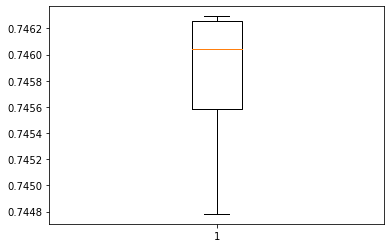

In [74]:
accs,test_loss, train_loss, w = K_Cross_Validation(x_train,y_train,4,0.001)
plt.boxplot(accs)
print(accs.mean())
print(test_loss)
print(train_loss)

## Tune Hyperparameters

In [75]:
def Tune_lambda(xt_training, y_training, K, gamma_range):
        
    lambdas = np.logspace(-7, gamma_range, 10)
    max_acc = 0
    min_loss = np.inf
    opt_lambda = 0
    accuracies = []
    train_losses = []
    test_losses = []
    for i, lambda_ in enumerate(lambdas):
       
        accuracy,test,train,w = K_Cross_Validation(xt_training, y_training, K,lambda_)
        accuracies.append([lambda_,np.median(accuracy)])
        train_losses.append([lambda_,np.median(train)])
        test_losses.append([lambda_,np.median(test)])
        if (np.median(test) < min_loss):
            min_loss = np.median(test)
            max_acc = np.median(accuracy)
            opt_lambda = lambda_
                
    return opt_lambda , max_acc, np.array(accuracies), np.array(train_losses), np.array(test_losses)
opt_lambda, max_acc, acc ,train, test= Tune_lambda(x_train, y_train, 5, 1)

print(f"optimal acc = {max_acc} with lambda= {opt_lambda}")

optimal acc = 0.7462888888888889 with lambda= 1e-07


## Predictions on Test Set 


In [77]:
w_opt,loss = ridge_regression(y_train,x_train,0.00001)
p = predict(w_opt,x_test)
print((p==y_test).mean())
print(loss)

0.75036
0.08474172818686453
